In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F

import scipy

from datetime import datetime
from sklearn.model_selection import KFold
import random

import tarfile
import os

## Uploading a dataset

In [ ]:
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
mod1, mod2, mod3, mod4 = 4, 5, 6, 7

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CUDA_DEV = 0
NUM_TAGS = 256

In [ ]:
link = '/content/drive/MyDrive/Yandex_cup/'
df_train = pd.read_csv(link+'train.csv')
df_test = pd.read_csv(link+'test.csv')

In [ ]:
# Путь к архиву
archive_path = link + 'track_embeddings.tar.gz'

# Распаковываем архив
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall('/content/track_embeddings')

# Теперь обрабатываем файлы
track_idx2embeds = {}
for fn in tqdm(glob('/content/track_embeddings/*')):
    track_idx = int(os.path.basename(fn).split('.')[0])
    embeds = np.load(fn)
    embeds = torch.from_numpy(embeds).to('cuda')
    track_idx2embeds[track_idx] = embeds

## feature engineering

Были добавлены:
- min
- max
- дисперсия
- стандартное отклонение
- корреляция / разница

Между строками, для каждого объекта

In [ ]:
def make_more_emb(data):
  # 404 - макс длина песни
  # data = track_idx2embeds[track_idx]
  data = data.to("cpu:0")
  data = data.mean(dim=1)
  kol = torch.tensor(data.shape[0], dtype=torch.int64).unsqueeze(0)
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
  std = torch.tensor(data.std(), dtype=data.dtype).unsqueeze(0)
  new_array = torch.zeros(404, dtype=data.dtype)
  new_array[:kol[0]] = data
  diff = torch.diff(new_array)
  new_array = torch.zeros(768-408, dtype=data.dtype)

  return torch.cat((kol, min_, max_, var, std, diff, new_array))

In [ ]:
for key, val in tqdm(track_idx2embeds.items()):
  emb = torch.cat((val.to("cpu:0"), make_more_emb(embeds.clone()).unsqueeze(0)), dim=0)
  # track_idx2embeds[key] = None
  track_idx2embeds[key] = emb.to('cuda')

  0%|          | 0/76714 [00:00<?, ?it/s]<ipython-input-16-49c48ecf6b20>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
<ipython-input-16-49c48ecf6b20>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
<ipython-input-16-49c48ecf6b20>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
<ipython-input-16-49c48ecf6b20>:10: UserWarning: To copy construct from 

In [ ]:
def make_more_emb2(data):
  # 404 - макс длина песни
  # data = track_idx2embeds[track_idx]
  data = data.to("cpu:0")
  data = torch.exp(data).mean(dim=1)
  kol = torch.tensor(data.shape[0], dtype=torch.int64).unsqueeze(0)
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
  std = torch.tensor(data.std(), dtype=data.dtype).unsqueeze(0)
  new_array = torch.zeros(404, dtype=data.dtype)
  new_array[:kol[0]] = data
  diff = torch.diff(new_array)
  new_array = torch.zeros(768-408, dtype=data.dtype)
  return torch.cat((kol, min_, max_, var, std, diff, new_array))

In [ ]:
for key, val in tqdm(track_idx2embeds.items()):
  emb = torch.cat((val.to("cpu:0"), make_more_emb2(embeds.clone()).unsqueeze(0)), dim=0)
  # track_idx2embeds[key] = None
  track_idx2embeds[key] = emb.to('cuda')

  0%|          | 0/76714 [00:00<?, ?it/s]<ipython-input-18-42fe75b13068>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
<ipython-input-18-42fe75b13068>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
<ipython-input-18-42fe75b13068>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
<ipython-input-18-42fe75b13068>:10: UserWarning: To copy construct from 

Создаем наследуемый класс для итерираций

In [ ]:
class TaggingDataset(Dataset):
    def __init__(self, df, testing=False):
        self.df = df
        self.testing = testing

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        track_idx = row.track
        embeds = track_idx2embeds[track_idx]
        if self.testing:
            return track_idx, embeds
        tags = [int(x) for x in row.tags.split(',')]
        target = np.zeros(NUM_TAGS)
        target[tags] = 1
        return track_idx, embeds, target

In [ ]:
train_dataset = TaggingDataset(df_train)
test_dataset = TaggingDataset(df_test, True)

## PCA

<Итерируясь по по строкам первого объекта - мы решили взять разницу между соседними средними по строкам, что улучшело скор>

In [ ]:
track_idx, embeds, target = train_dataset[0]
emb = embeds[:10].to("cpu:0")

In [ ]:
def print_target(target):
  # Получите индексы с ненулевыми значениями
  nonzero_indices = np.nonzero(target)

  # nonzero_indices - это кортеж с двумя массивами: один для индексов строк и другой для индексов столбцов
  row_indices = nonzero_indices

  # Выведите индексы с ненулевыми значениями
  for i in range(len(row_indices)):
      print(f"Row: {row_indices[i]}")

In [ ]:
# best ones
mean_batch = torch.log(emb.abs() + 1e-6).std(dim=1).to('cpu')
mean_batch = torch.sqrt(torch.mean(emb**2, dim=1)).to('cpu')

mean_batch = np.correlate(emb[0].cpu().numpy(), emb[0].cpu().numpy(), mode='full')
data_array = data



In [ ]:
def print_subplots(emb):
  # Your data as a tensor (assuming 'data' is your tensor)
  mean_batch = torch.sqrt(torch.mean(emb**2, dim=1)).to('cpu')
  data = mean_batch
  print(data.size())

  # Convert the tensor to a NumPy array
  data_array = data.numpy()

  # Create a list of indices for x-axis
  indices = list(range(len(data_array)))

  # Create a scatter plot
  plt.scatter(indices, data_array, marker='o', s=10)  # 'o' represents the marker style, and 's' sets the marker size

  # Set labels and title
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Distribution of Points')

  # Show the plot
  plt.show()

torch.Size([74])


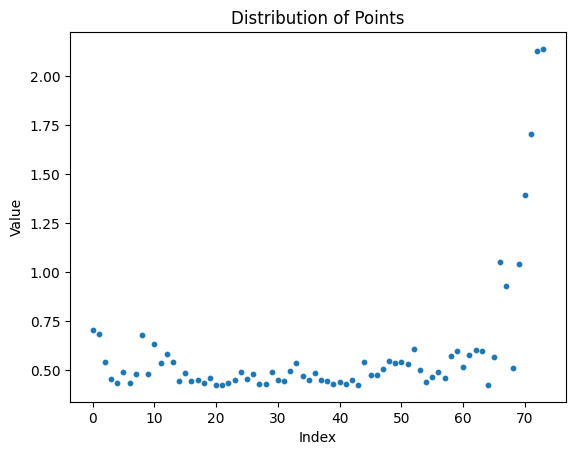

Row: [ 5  6  9 26 32 55 96]
torch.Size([59])


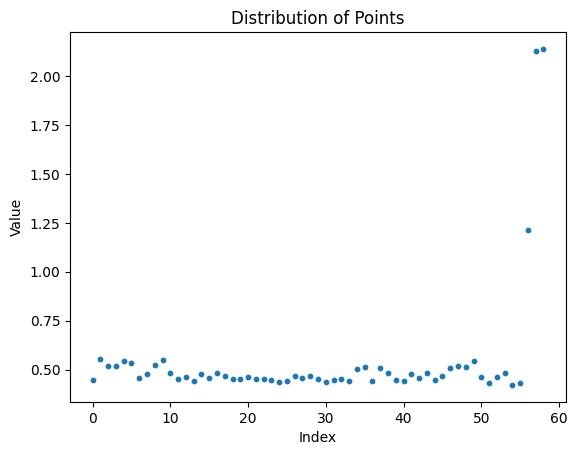

Row: [  6   9  28  39 145 155]
torch.Size([74])


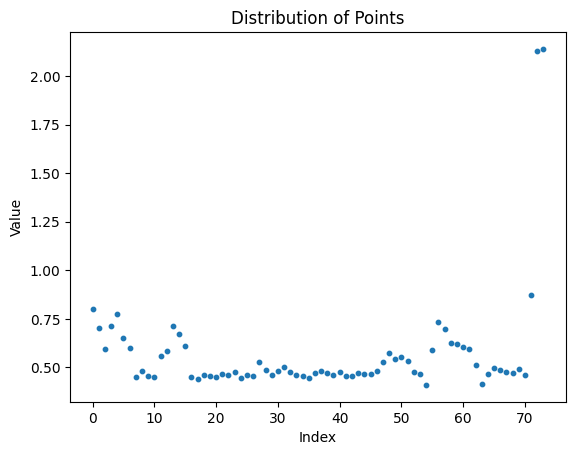

Row: [  0   6  28  40 116 168]
torch.Size([54])


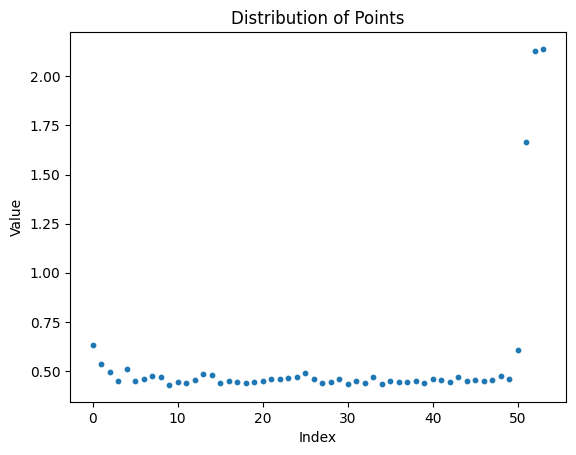

Row: [ 28 186]
torch.Size([27])


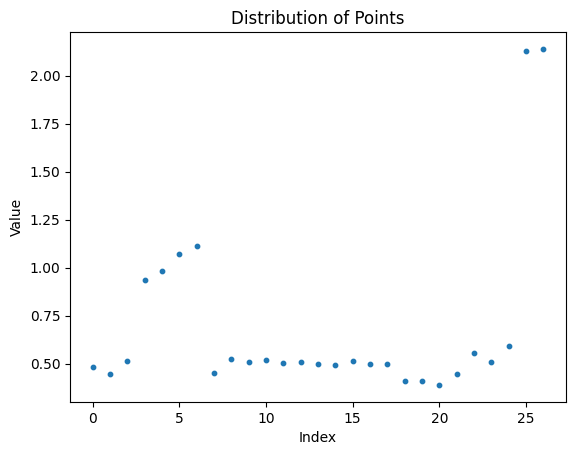

Row: [  6  23 177]
torch.Size([65])


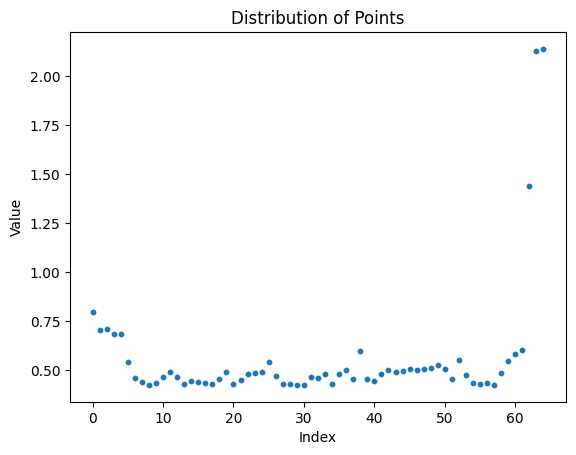

Row: [ 43 183 252]
torch.Size([36])


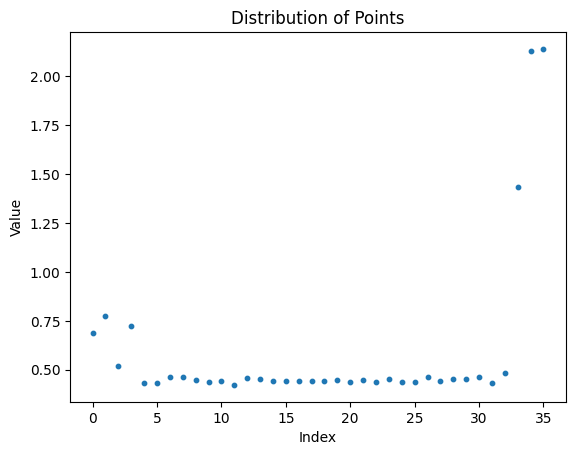

Row: [ 0 10 48]
torch.Size([52])


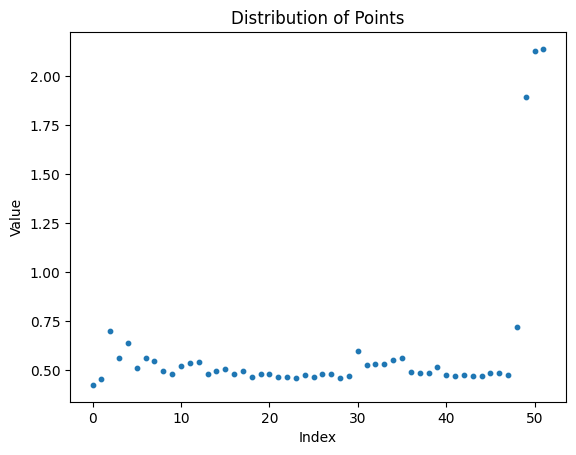

Row: [ 35 112 191]
torch.Size([49])


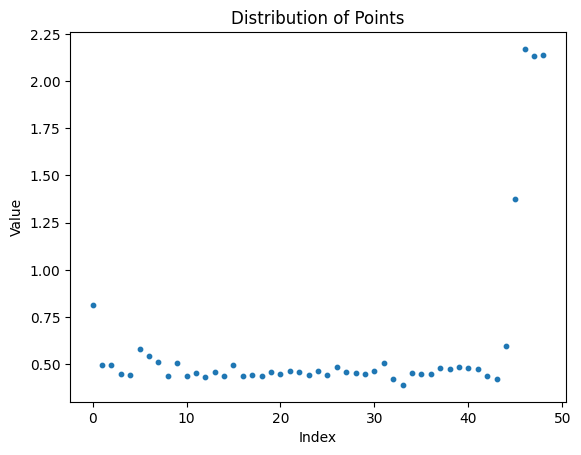

Row: [ 0 16]
torch.Size([61])


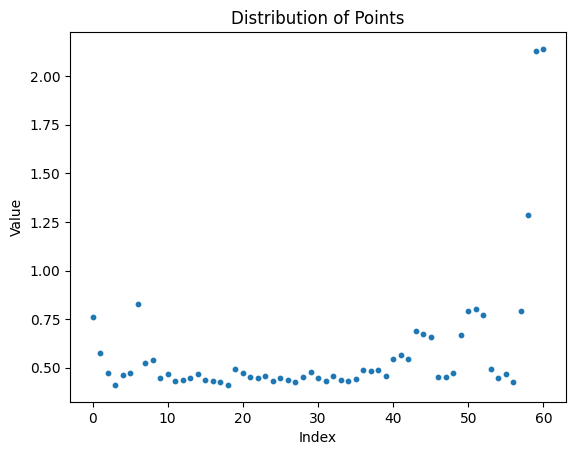

Row: [  6   9  32  85 122]


In [ ]:
for i in range(10):
  track_idx, embeds, target = train_dataset[i]
  print_subplots(embeds)
  print_target(target)

## Пример обучения FC моделей по методу K-fold

In [ ]:
def Block_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWBN_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class let_Net_gun(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 512,
        hidden = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = Block_brick(hidden, 512)
        self.lin_2 = Block_brick(512, 1024)
        self.lin_3 = BlockWBN_brick(1024, 1200)
        self.lin_4 = Block_brick(1200, 1580)
        self.lin_5 = BlockWBN_brick(1580, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration, data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss
            ))

In [ ]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(df_train)):
    seed_everything(seed=fold)
    print(f'Fold {fold + 1}, {fold+1}')

    # Разделите данные на обучающий и тестовый наборы
    train_data = df_train.iloc[train_idx]

    train_dataset1 = TaggingDataset(df_train)
    train_dataloader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True, collate_fn=collate_fn)
    model1 = let_Net_gun().to('cuda')
    criterion = nn.BCEWithLogitsLoss().to('cuda')
    optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
    epochs = 30

    for epoch in tqdm(range(epochs)):
        train_epoch(model1, train_dataloader1, criterion, optimizer)

    # Сохранение модели в файл
    torch.save(model1, link+f'model/{fold+1}__my_model1_{mod}.pth')


In [ ]:
# выгрузка моделей
loaded_model1 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/1__my_model1_1.pth')
loaded_model2 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2__my_model1_2.pth')
loaded_model3 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/3__my_model1_3.pth')
loaded_model4 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/4__my_model1_4.pth')
loaded_model5 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/5__my_model1_5.pth')

# The final solution

В решении использовался блендинг из таких моделей:
- FC (6 hidden layers) **[best]**
- CNN (5 convolution + 3 hidden layers)
- LSTM (5 hidden layers)
- BIG FC (8 hidden layers)
- FC with k-fold learning metod

### Regular FC

In [ ]:
def Block_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWBN_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class let_Net_gun(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 512,
        hidden = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = Block_brick(hidden, 512)
        self.lin_2 = Block_brick(512, 1024)
        self.lin_3 = BlockWBN_brick(1024, 1200)
        self.lin_4 = Block_brick(1200, 1580)
        self.lin_5 = BlockWBN_brick(1580, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

### CNN model

In [ ]:
class let_Cnn_gun(nn.Module):
    def __init__(self, num_classes=NUM_TAGS, input_dim=768, hidden_dim=768):
        super().__init__()
        self.conv1_gun = nn.Conv1d(in_channels=512, out_channels=768, kernel_size=3, stride=1, padding=1)
        self.conv2_gun = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv3_gun = nn.Conv1d(512, 1200, kernel_size=3, stride=1, padding=1)
        self.conv4_gun = nn.Conv1d(1200, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_gun = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(1024, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.projector =  nn.Linear(input_dim, 512)
        self.bn = nn.LayerNorm(512)
        self.skip = nn.Conv1d(768, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, embeds):
        x = [self.relu(self.projector(x)) for x in embeds]  # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x]  # 64,1,512
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x]  # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))]  # 64,2,512
        x = torch.stack(x_r, dim=0)  # 64,2,512
        x = self.bn(x)  # 64,2,512
        x = x.permute(0, 2, 1)

        x = self.relu(self.conv1_gun(x))
        skip1 = self.skip(x)
        x = self.pool(x)
        x = self.relu(self.conv2_gun(x))
        x = x + skip1
        skip2 = x
        x = self.relu(self.conv3_gun(x))
        x = self.relu(self.conv4_gun(x))
        x = skip2 + x
        x = self.relu(self.conv5_gun(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### LSTM model

In [ ]:
def Block_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWBN_brick(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )

class log_LSTM_gun(nn.Module):
    def __init__(self, input_size=768, hidden_size=768, num_classes=256):
        super().__init__()
        self.num_classes = num_classes
        self.lin_1 = Block_brick(512, 800)
        self.lin_2 = Block_brick(800, 1000)
        self.lin_3 = BlockWBN_brick(1000, 1200)
        self.lin_4 = Block_brick(1200, 1315)
        self.lin_5 = BlockWBN_brick(1315, 768)
        self.fc = nn.Linear(768, num_classes)
        self.drop = nn.Dropout(0.3)

        self.relu = nn.LeakyReLU()
        self.projector =  nn.Linear(input_size, 512)
        self.bnorm = nn.LayerNorm(512)
        self.lstms = nn.ModuleList([nn.LSTM(512, 512, batch_first=True, bidirectional=True) for _ in range(2)])

    def forward(self, embeds):
        # 64,X,768
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [v.std(dim=0).unsqueeze(0) for v in x]  # 64,1,512 --> v.size = X,512 --> we apply std by columns (512) and add dim (1,512)

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = self.bnorm(x)  # 64,2,512

        k = 0
        for lstm in self.lstms:
            x, (hn, cn) = lstm(x)
            if k == 1:
              x = hn[-1]
            else:
              x = hn[-1].unsqueeze(1)
            k += 1
        # x.size() = 64,512
        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

### Big FC

In [ ]:
def B(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BWBN(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class big_Net(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 256,
        hidden = 256
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = B(hidden, 512)
        self.lin_2 = B(512, 1024)
        self.lin_3 = BWBN(1024, 1200)
        self.lin_4 = B(1200, 1580)
        self.lin_5 = BWBN(1580, hidden_dim)
        self.lin_6 = B(hidden_dim, hidden_dim)
        self.lin_7 = BWBN(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        x = self.lin_6(x)
        x = self.lin_7(x)
        outs = self.fc(x)
        return outs

### Unloading models

In [ ]:
k_fold_model1 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/1__my_model1_29.pth')
k_fold_model2 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2__my_model1_25.pth')
k_fold_model3 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/3__my_model1_2.pth')
k_fold_model4 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/4__my_model1_77.pth')
k_fold_model5 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/5__my_model1_86.pth')

In [ ]:
first_model1 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 16_08_14_my_model1.pth')
first_model2 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 16_08_14_my_model2.pth')
first_model3 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 16_08_14_my_model3.pth')
first_model4 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 16_08_14_my_model4.pth')

In [ ]:
second_model1 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 14_16_16_my_model1.pth')
second_model2 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 14_16_16_my_model2.pth')
second_model3 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 14_16_16_my_model3.pth')
second_model4 = torch.load(f'/content/drive/MyDrive/Yandex_cup/model/2023-11-12 14_16_16_my_model4.pth')

### Predicting

In [ ]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [ ]:
test_dataset = TaggingDataset(df_test, True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

In [ ]:
def predict(models1, models2, k_fold, loader):
    for model_x in k_fold:
      model_x.eval()
    model1, model2, model3, model4, model5 = k_fold
    model1_1, model2_1, model3_1, model4_1 = models1
    model1_2, model2_2, model3_2, model4_2 = models2
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(CUDA_DEV) for x in embeds]

            # bagging with weights (depends on impact of model)
            k1, k2, k3, k4 = 0.35, 0.15, 0.15, 0.25
            pred_logits_1 = (k1 * model1_1(embeds) + k2 * model2_1(embeds) + k3 * model3_1(embeds) + k4 * model4_1(embeds)) / 4
            pred_logits_2 = (k1 * model1_2(embeds) + k2 * model2_2(embeds) + k3 * model3_2(embeds) + k4 * model4_2(embeds)) / 4
            pred_logits_k_fold = (model1(embeds) + model2(embeds) + model3(embeds) + model4(embeds) + model5(embeds)) / 5
            pred_logits = (1 * pred_logits_1 + 0.8 * pred_logits_2 + 0.8 * pred_logits_k_fold) / 3

            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

In [ ]:
models1 = [first_model1, first_model2, first_model3, first_model4]
models2 = [second_model1, second_model2, second_model3, second_model4]
k_fold = [k_fold_model1, k_fold_model2, k_fold_model3, k_fold_model4, k_fold_model5]
track_idxs, predictions = predict(models1, models2, k_fold, test_dataloader)

In [ ]:
track_idxs, predictions = predict(models1, models2, k_fold, test_dataloader)

In [ ]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])

In [ ]:
predictions_df.to_csv(link+ 'model/prediction.csv', index=False)